# Simulation graph

In [196]:
import dgl
from dgl.data import DGLDataset
import torch
import itertools
import numpy as np
import random
import json
import os
import subprocess
import pickle
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt

SCALE = 50
SEPARATE = False # whether process x-axis and y-axis as separate label 
DIRECTED = True # whether use directed graph
SAVE = True # whether save the result
SAVE_NAME = 'predc'
ORDER_NODE = True # if you want to add the order of the node as input feature
CROSSINGS = 5 # max number of random edges you want to add in a graph 
MIN_PER_NODE = 0 # Nodes/Rank: How 'fat' the DAG should be.  
MAX_PER_NODE = 3
MIN_RANKS = 1 # Ranks: How 'tall' the DAG should be.  */
MAX_RANKS = 3
NUM_SAMPLES=10 #number of graphs you want to draw

graphs = []
labels = []
labels_x = []
labels_y = []
times=[]

os.chdir('D:\\Career\\DS-ML\\1cademy\\research\\data\\training\\')

In [197]:
def process_single_graph(data):#input is str directly read from one txt file
    #-----------data cleaning and rearranging--------
    data=data.replace('true','True')
    data=data.replace('false','False')
    data='g='+str(data)
    lcls = locals()
    exec(data, globals(), lcls )
    g = lcls["g"]
    # process to attributes
    G = dgl.DGLGraph()
    G.add_nodes(g['_nodeCount'])
    in_=[]
    out_=[]
    for e in g['_edgeObjs'].keys():
        out_.append(int(g['_edgeObjs'][e]['v'][1:]))
        in_.append(int(g['_edgeObjs'][e]['w'][1:]))
    out_=torch.tensor(out_,dtype=torch.long)
    in_=torch.tensor(in_,dtype=torch.long)
    G.add_edges(out_,in_)
    if ORDER_NODE==True:
        x_=[(g['_nodes']['n'+str(node)]['width']/SCALE,g['_nodes']['n'+str(node)]['height']/SCALE, node) for node in range(g['_nodeCount'])]
    else:
        x_=[(g['_nodes']['n'+str(node)]['width']/SCALE,g['_nodes']['n'+str(node)]['height']/SCALE) for node in range(g['_nodeCount'])]
    y_=[(g['_nodes']['n'+str(node)]['x']/SCALE,g['_nodes']['n'+str(node)]['y']/SCALE) for node in range(g['_nodeCount'])]
    y_=list(itertools.chain.from_iterable(y_))
    G.ndata['x']=torch.tensor(x_,dtype=torch.double)
    try:
        n_edge=g['_edgeCount']
    except:
        n_edge=0
    G.edata['x']=torch.tensor(np.zeros((n_edge,1)),dtype=torch.double)
    return (G,y_)


def process_single_graph_sep(data):#input is str directly read from one txt file
    # data cleaning and rearranging
    data=data.replace('true','True')
    data=data.replace('false','False')
    data='g='+str(data)
    lcls = locals()
    exec(data, globals(), lcls )
    g = lcls["g"]
    # process to attributes
    G = dgl.DGLGraph()
    G.add_nodes(g['_nodeCount'])
    in_=[]
    out_=[]
    for e in g['_edgeObjs'].keys():
        out_.append(int(g['_edgeObjs'][e]['v'][1:]))
        in_.append(int(g['_edgeObjs'][e]['w'][1:]))
    out_=torch.tensor(out_,dtype=torch.long)
    in_=torch.tensor(in_,dtype=torch.long)
    G.add_edges(out_,in_)
    if ORDER_NODE==True:
        x_=[(g['_nodes']['n'+str(node)]['width']/SCALE,g['_nodes']['n'+str(node)]['height']/SCALE, node) for node in range(g['_nodeCount'])]
    else:
        x_=[(g['_nodes']['n'+str(node)]['width']/SCALE,g['_nodes']['n'+str(node)]['height']/SCALE) for node in range(g['_nodeCount'])]
    y_=[(g['_nodes']['n'+str(node)]['x']/SCALE,g['_nodes']['n'+str(node)]['y']/SCALE) for node in range(g['_nodeCount'])]
    y_horizontal=[g['_nodes']['n'+str(node)]['x']/SCALE for node in range(g['_nodeCount'])]
    y_vertical=[g['_nodes']['n'+str(node)]['y']/SCALE for node in range(g['_nodeCount'])]
    G.ndata['x']=torch.tensor(x_,dtype=torch.double)
    try:
        n_edge=g['_edgeCount']
    except:
        n_edge=0
    G.edata['x']=torch.tensor(np.zeros((n_edge,1)),dtype=torch.double)
    return (G, y_horizontal, y_vertical)


In [198]:
def sample():
    '''
    nodes in the same rank are not connected
    nodes without any connection can stil be in nodelist
    there could be edge between each nodes pair as long as theses
    two nodes are in different ranks (generated by chance)
    width is 40, height is random from 10,20,30,... 110
    '''
    for i in tqdm(range(NUM_SAMPLES)):
        num_seed_node=int(np.random.uniform(0,1)*(3+1-1))+1#first layer of nodes, and they will never connect to each other
        K=int(np.random.uniform(0,1)*(MAX_RANKS+1-MIN_RANKS))+MIN_RANKS#ranks of this graph
        idx=0
        nodes_cur=[i for i in range(num_seed_node)]
        dag=dict({'nodes':list(),'edges':list()})
        G = dgl.DGLGraph()
        num_edges=0

        #add initial nodes to sets
        for i in range(num_seed_node):
            dag['nodes'].append({'label':'n'+str(idx),'width':40,'height':int(random.random()*(10-1+1)+1)*10})
            idx+=1

        #add nodes layer by layer
        for i in range(K):
            order=0
            for node in nodes_cur.copy():
                nodes_cur.pop(0)
                num_children=int(np.random.uniform(0,1)*(MAX_PER_NODE+1-MIN_PER_NODE))+MIN_PER_NODE
                #add new nodes and edges to graphs
                for j in range(num_children):
                    dag['nodes'].append({'label':'n'+str(idx),'width':40,'height':int(random.random()*(10-1+1)+1)*10})
                    nodes_cur.append(idx)
                    dag['edges'].append({'parent':'n'+str(node),'child':'n'+str(idx)})
                    idx+=1
                    num_edges+=1
        dag['n_nodes']=len(dag['nodes'])
        if CROSSINGS>0 and dag['n_nodes']>1:
            sp = random.sample(range(0, CROSSINGS), 1)
            for i in range(sp[0]):
                candidate = random.sample(range(0, dag['n_nodes']), 2)
                candidate = {'parent':'n'+str(candidate[0]),'child':'n'+str(candidate[1])}
                if candidate not in dag['edges']:
                    num_edges+=1
                    dag['edges'].append(candidate)
        dag['n_edges']=num_edges
        with open('data.json', 'w', encoding="utf-8") as f:
            json.dump(dag, f)  
        subprocess.run('node index.js',shell=True, capture_output=True)
        filename='graph.txt'
        text_file = open(filename, "r")
        data = text_file.read()
        text_file.close()
        filename='time.txt'
        text_file = open(filename, "r")
        time = text_file.read()
        text_file.close()
        time=(time.split(','))
        # process and add to dataset
        if SEPARATE==True:
            (g,label_x,label_y)=process_single_graph_sep(data)
            if DIRECTED==False:
                n=g.ndata
                e=g.edata
                g=dgl.to_bidirected(g)
                g.ndata['x']=n['x']
                g.edata['x']=torch.zeros((e['x'].size()[0]*2,1),dtype=torch.float64)
            graphs.append(g)
            labels_x.append(label_x)
            labels_y.append(label_y)
            times.append(time)
        else:
            (g,label)=process_single_graph(data)
            if DIRECTED==False:
                n=g.ndata
                e=g.edata
                g=dgl.to_bidirected(g)
                g.ndata['x']=n['x']
                g.edata['x']=torch.zeros((e['x'].size()[0]*2,1),dtype=torch.float64)
            graphs.append(g)
            labels.append(label)
            times.append(time)
        if SEPARATE==True:
            trim_sep()
        else:
            trim()
    return None


def trim(dim_max=256):
    y_dim=dim_max
    for i in labels:
        if len(i)<y_dim:
            i+=[0]*(y_dim-len(i))
    n=len(labels)
    for i in range(n-1,-1,-1):
        if len(labels[i])>dim_max:
            graphs.pop(i)
            labels.pop(i)
            times.pop(i)
    return None
    
def save():
    SAVE_NAME
    name = 'graphs_' + SAVE_NAME + '.obj'
    filehandler = open(name,"wb")
    pickle.dump(graphs,filehandler)
    filehandler.close()
    name = 'labels_' + SAVE_NAME + '.obj'
    filehandler = open(name,"wb")
    pickle.dump(labels,filehandler)
    filehandler.close()
    name = 'times_' + SAVE_NAME + '.obj'
    filehandler = open(name,"wb")
    pickle.dump(times,filehandler)
    filehandler.close()
    
def trim_sep(dim_max=128):
    y_dim=dim_max
    for i in labels_x:
        if len(i)<y_dim:
            i+=[0]*(y_dim-len(i))
    for i in labels_y:
        if len(i)<y_dim:
            i+=[0]*(y_dim-len(i))
    n=len(labels_x)
    for i in range(n-1,-1,-1):
        if len(labels_x[i])>y_dim:
            graphs.pop(i)
            labels_x.pop(i)
            labels_y.pop(i)
            times.pop(i)

def save_sep():
    name = 'graphs_' + SAVE_NAME + '.obj'
    filehandler = open(name,"wb")
    pickle.dump(graphs,filehandler)
    filehandler.close()
    name = 'labelx_' + SAVE_NAME + '.obj'
    filehandler = open(name,"wb")
    pickle.dump(labels_x,filehandler)
    filehandler.close()
    name = 'labely_' + SAVE_NAME + '.obj'
    filehandler = open(name,"wb")
    pickle.dump(labels_y,filehandler)
    filehandler.close()
    name = 'times_' + SAVE_NAME + '.obj'
    filehandler = open(name,"wb")
    pickle.dump(times,filehandler)
    filehandler.close()

In [199]:
def plot_knowledge_graph(g, label_x=None, label_y=None, labels=None):
    if labels!=None:
        label_x=labels[0::2]
        label_y=labels[1::2]
    height = max(label_y)*SCALE+100
    width = max(label_x)*SCALE+50
    n_nodes=len(g.nodes())
    n_edges=len(g.edges()[0])
    fig, ax = plt.subplots(figsize=(100, 25))
    plt.xlim([-50, width])
    plt.ylim([-50, height])
    plt.gca().set_aspect('equal', adjustable='box')
    dic_pt=dict()
    #draw nodes
    for i in range(n_nodes):
        c = (label_x[i]*SCALE, label_y[i]*SCALE)
        h = g.ndata['x'][i][1]*SCALE
        w = g.ndata['x'][i][0]*SCALE
        x0 = c[0]-w/2
        x1 = c[0]+w/2
        y0 = c[1]-h/2
        y1 = c[1]+h/2
        x = [x0, x0, x1, x1, x0]
        y = [y0, y1, y1, y0, y0]
        dic_pt[int(g.nodes()[i])] = [(x0, c[1]),(x1, c[1])]
        plt.plot(x, y, color='green')
    #draw edges
    for i in range(n_edges):
        x0 = dic_pt[int(g.edges()[0][i])][1][0]
        y0 = dic_pt[int(g.edges()[0][i])][1][1]
        x1 = dic_pt[int(g.edges()[1][i])][0][0]
        y1 = dic_pt[int(g.edges()[1][i])][0][1]
        x = [x0, x1]
        y = [y0, y1]
        plt.plot(x, y, color='green')
    plt.show()

In [200]:
sample()
if SAVE==True:
    if SEPARATE==True:
        labels_x=torch.tensor(labels_x,dtype=torch.double)
        labels_y=torch.tensor(labels_y,dtype=torch.double)
        save_sep()
    else:
        labels=torch.tensor(labels,dtype=torch.double)
        save()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.15it/s]


In [104]:
g=graphs[0]
g.add_edges([0,1],[1,2])

In [ ]:
labels[3]

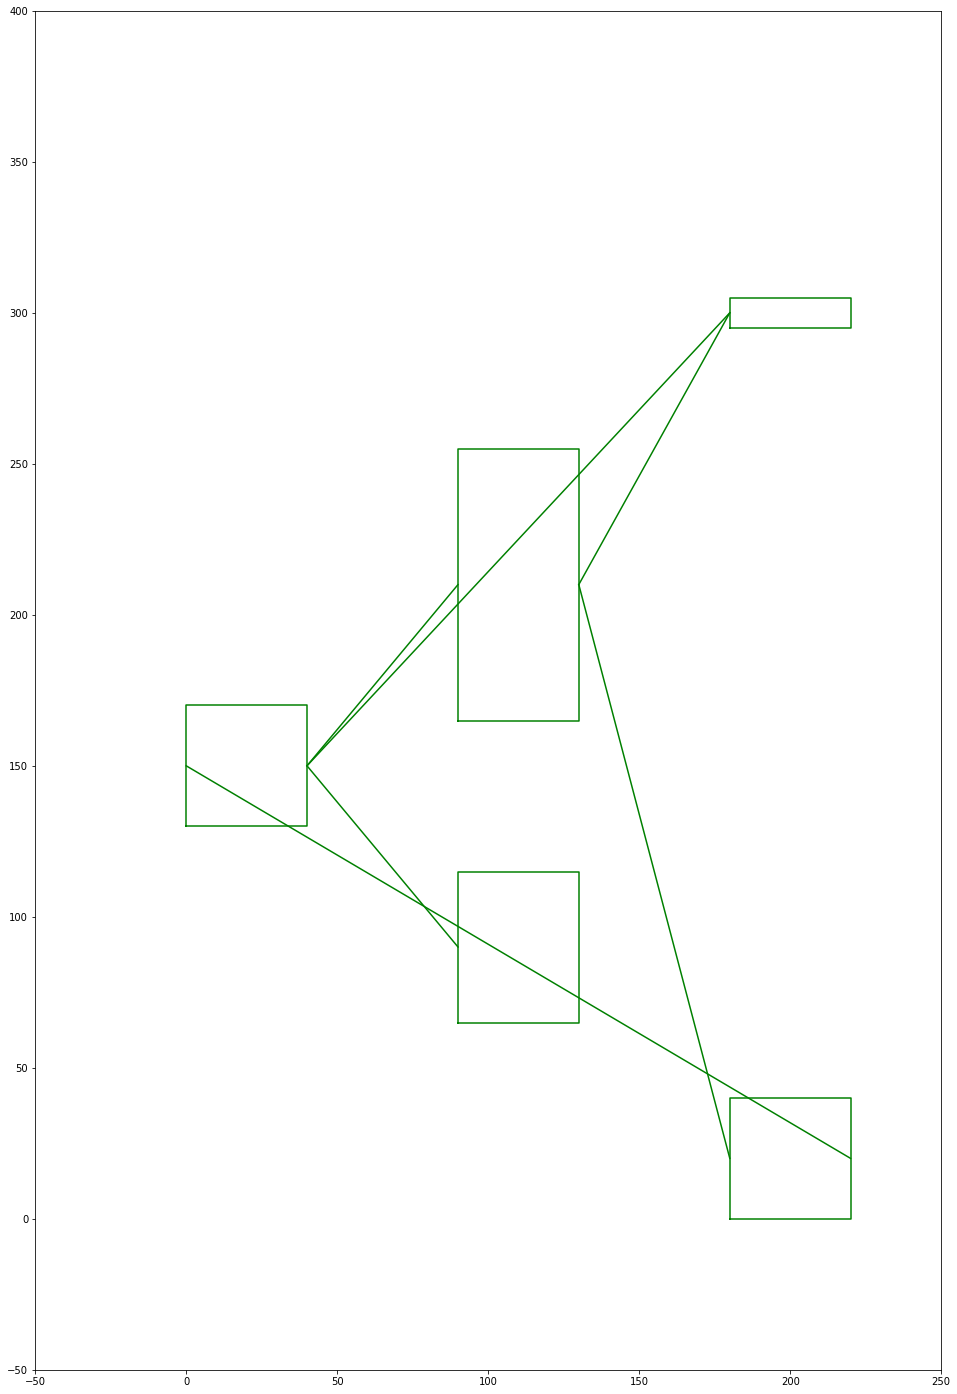

In [210]:
i=6
plot_knowledge_graph(graphs[i], labels=labels[i])

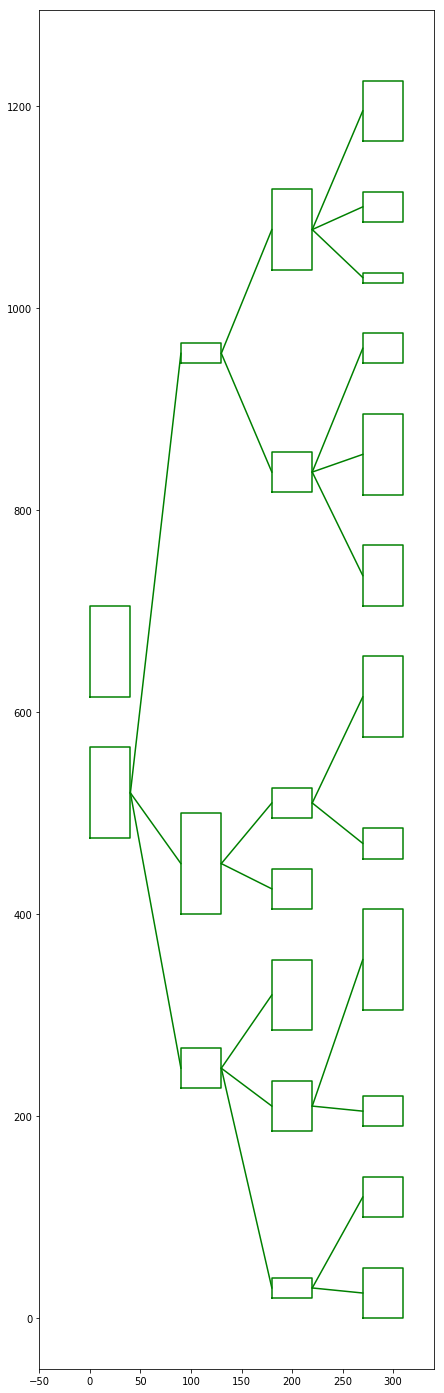

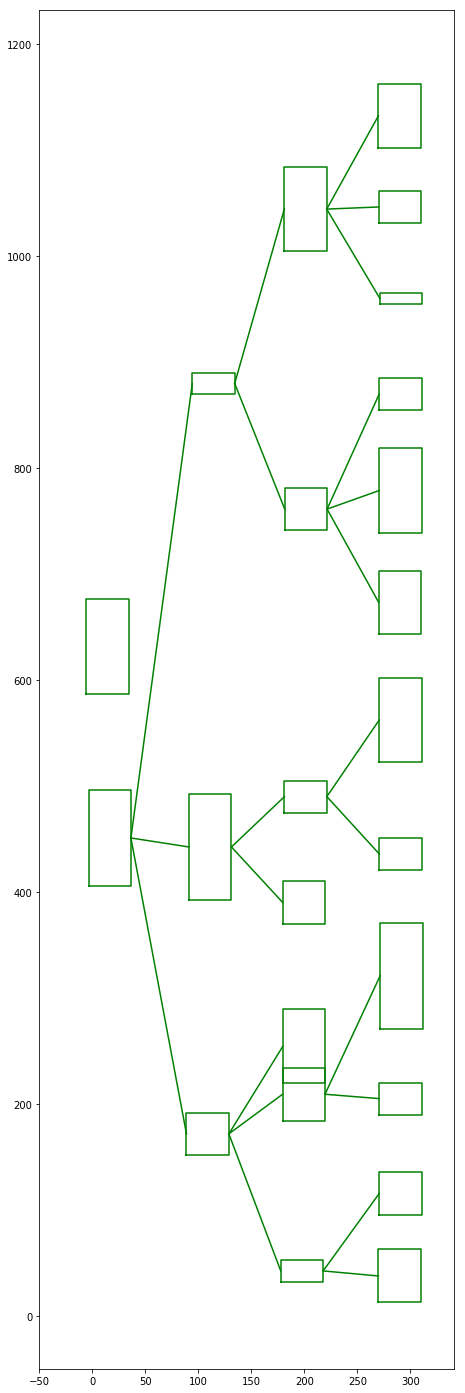

In [9]:
#dagre plot
plot_knowledge_graph(graphs[0], labels=labels[0])
labels_pred=torch.tensor([[[ 0.3257,  9.0156],
         [ 0.2825, 12.6328],
         [ 2.1738,  3.4336],
         [ 2.2227,  8.8438],
         [ 2.2832, 17.5938],
         [ 3.9531,  0.8467],
         [ 3.9863,  4.1797],
         [ 3.9922,  5.0859],
         [ 3.9922,  7.7930],
         [ 4.0234,  9.7969],
         [ 4.0273, 15.2188],
         [ 4.0195, 20.8750],
         [ 5.7969,  0.7510],
         [ 5.8125,  2.3066],
         [ 5.8086,  4.0977],
         [ 5.8281,  6.4219],
         [ 5.8164,  8.7109],
         [ 5.8125, 11.2422],
         [ 5.8008, 13.4609],
         [ 5.8086, 15.5703],
         [ 5.8125, 17.3906],
         [ 5.8242, 19.1875],
         [ 5.8008, 20.9219],
         [ 5.7930, 22.6406]]], dtype=torch.float16)
lx=[i[0] for i in labels_pred[0]]
ly=[i[1] for i in labels_pred[0]]
plot_knowledge_graph(graphs[0], label_x=lx, label_y=ly)

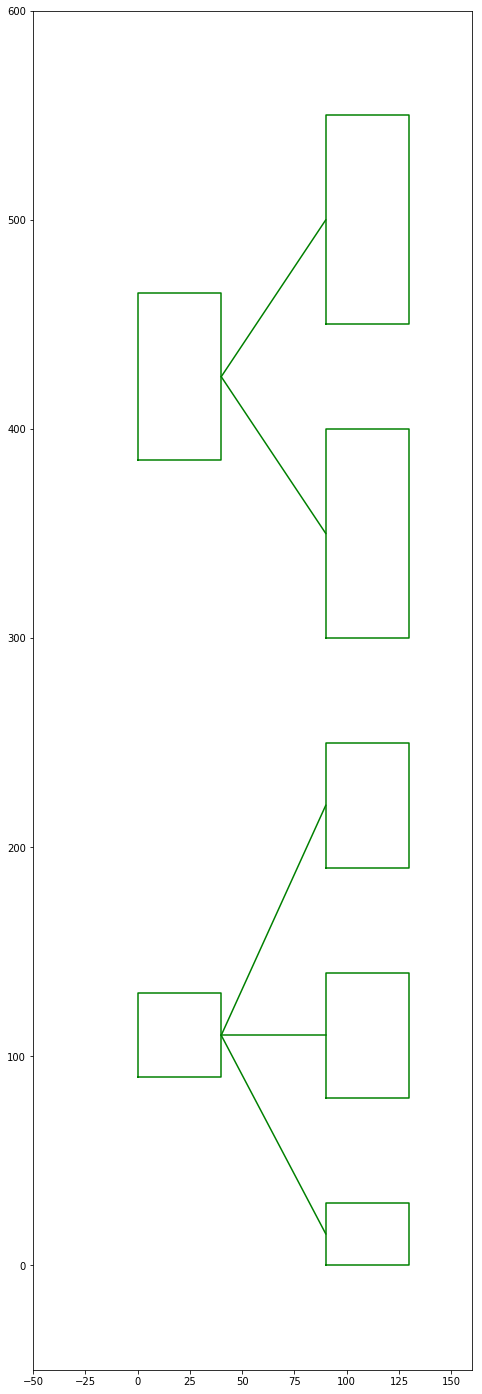

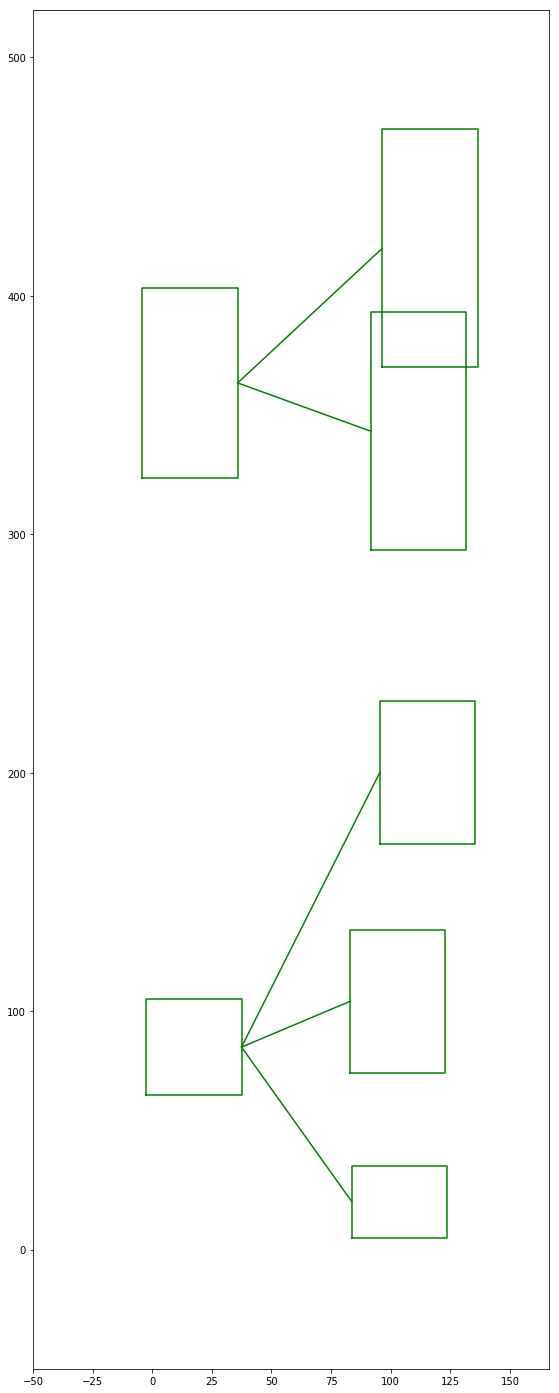

In [13]:
#dagre plot
plot_knowledge_graph(graphs[1], labels=labels[1])
labels_pred=torch.tensor([[[0.3486, 1.6982],
         [0.3164, 7.2695],
         [2.0762, 0.3984],
         [2.0586, 2.0820],
         [2.3105, 4.0039],
         [2.2324, 6.8633],
         [2.3301, 8.3984]]], dtype=torch.float16)
lx=[i[0] for i in labels_pred[0]]
ly=[i[1] for i in labels_pred[0]]
plot_knowledge_graph(graphs[1], label_x=lx, label_y=ly)

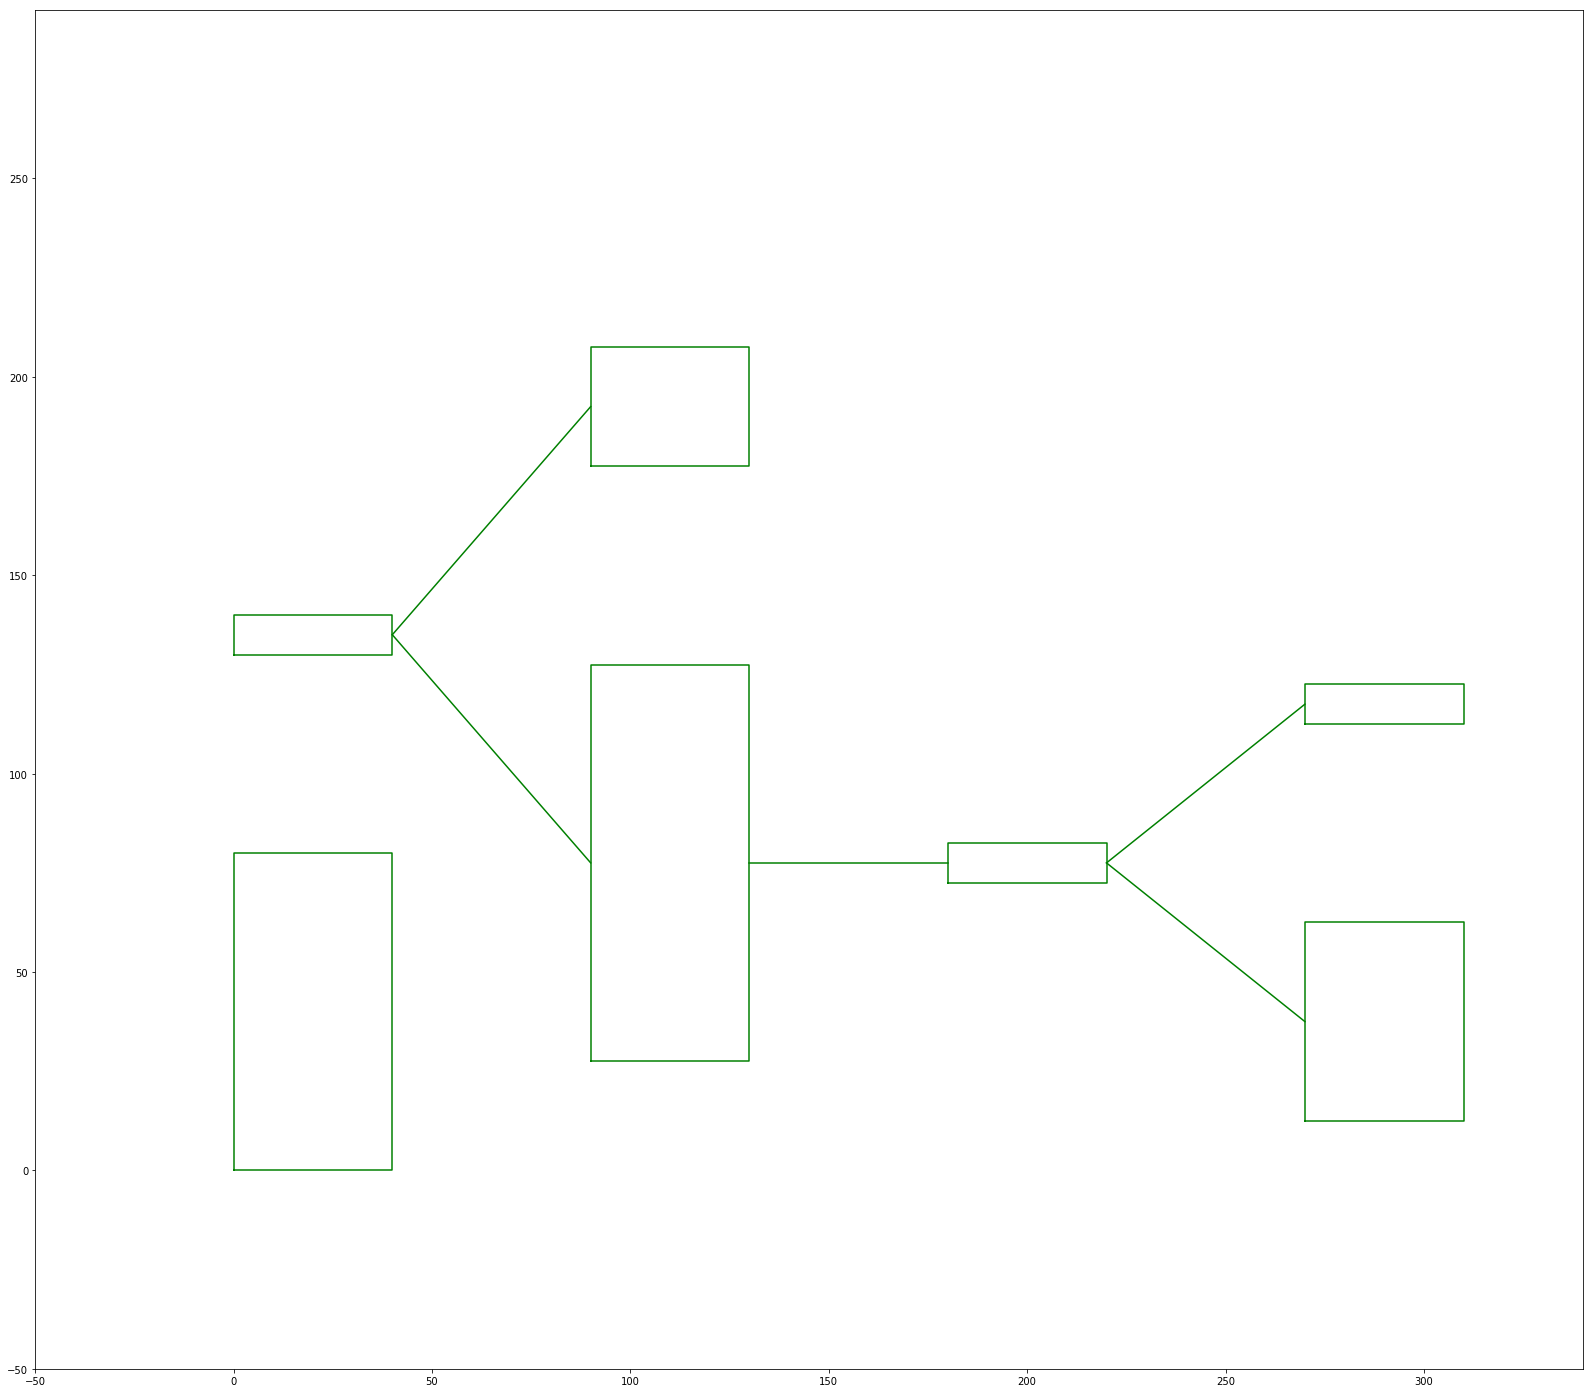

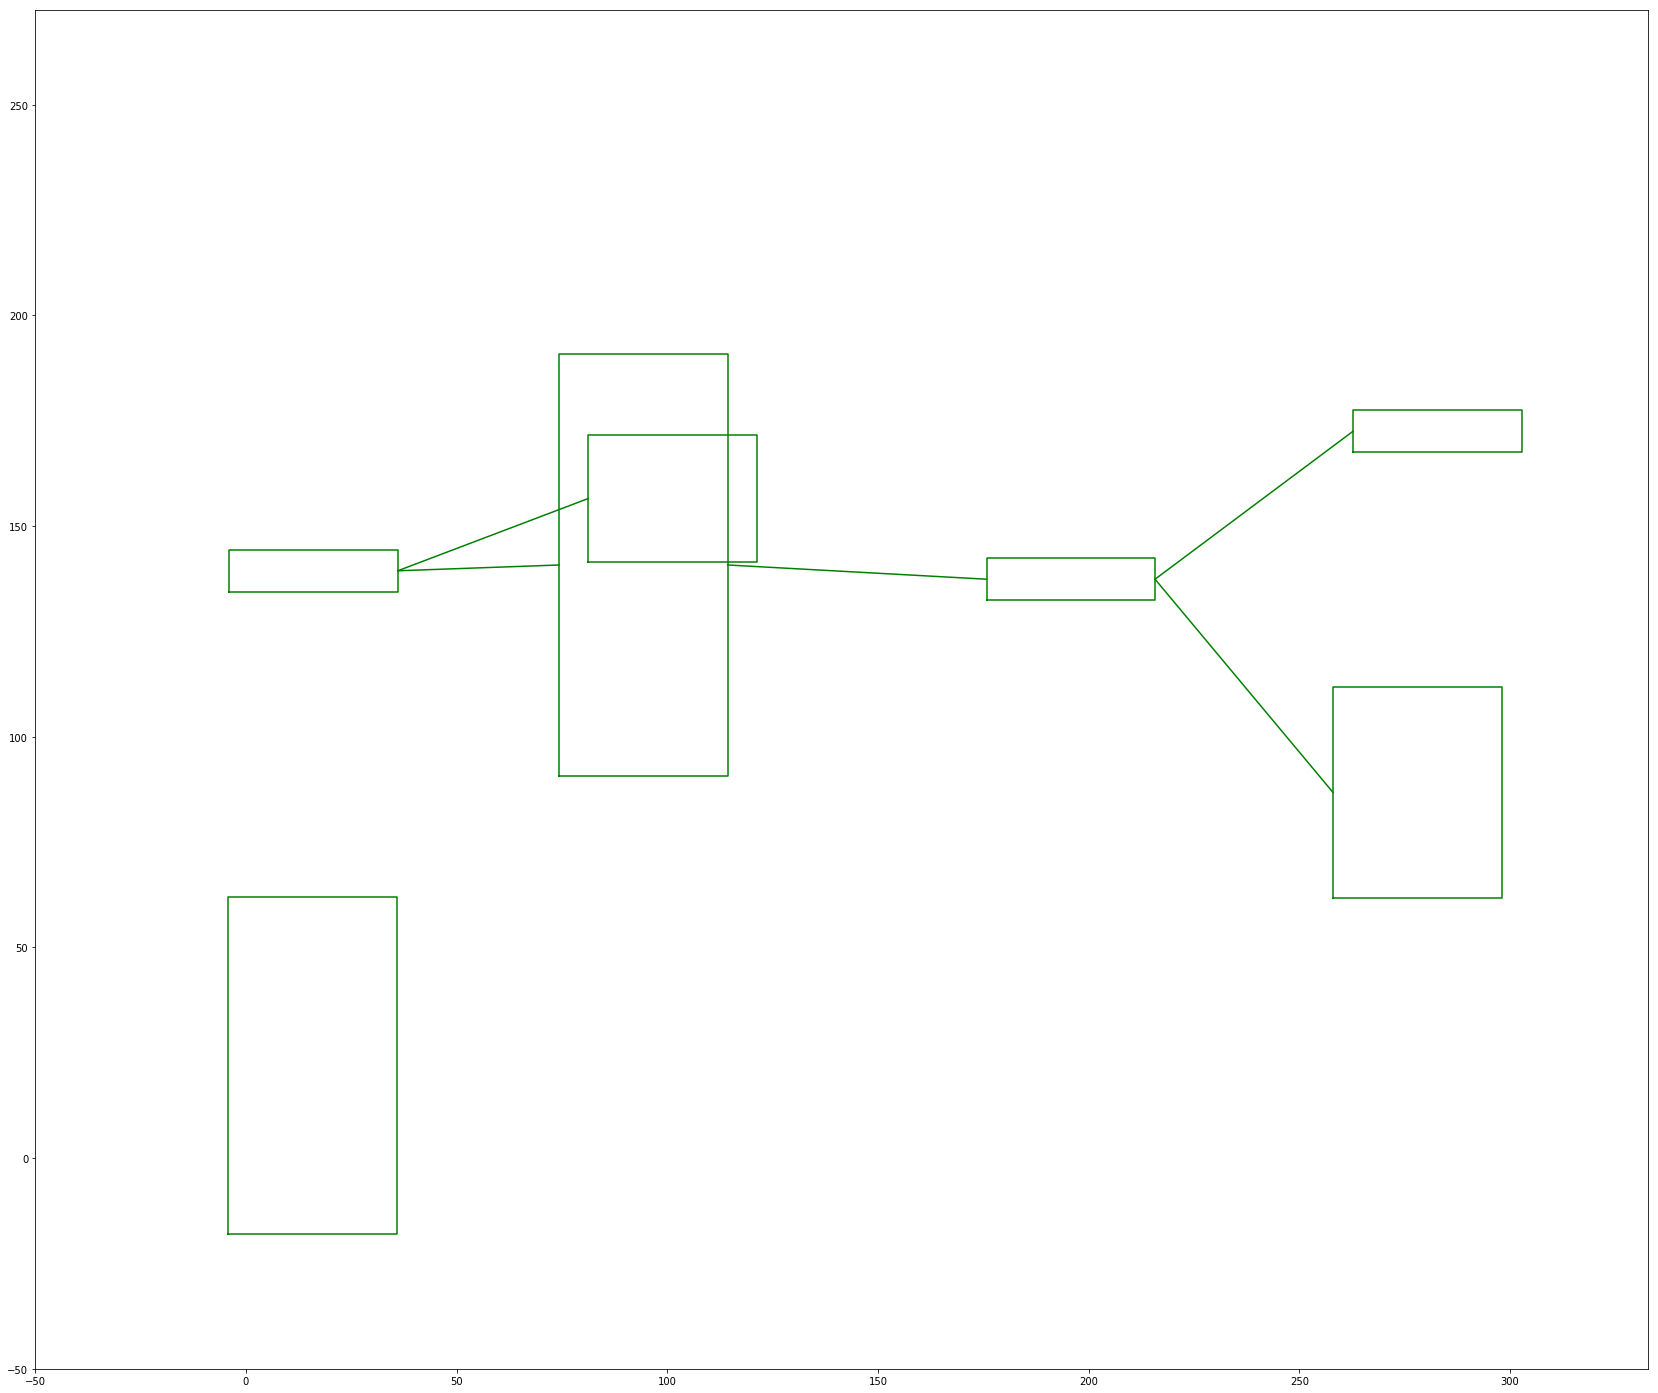

In [17]:
#dagre plot
plot_knowledge_graph(graphs[3], labels=labels[3])
labels_pred=torch.tensor([[[0.3174, 0.4409],
         [0.3208, 2.7871],
         [1.8867, 2.8145],
         [2.0234, 3.1289],
         [3.9160, 2.7480],
         [5.5586, 1.7344],
         [5.6562, 3.4512]]],  dtype=torch.float16)
lx=[i[0] for i in labels_pred[0]]
ly=[i[1] for i in labels_pred[0]]
plot_knowledge_graph(graphs[3], label_x=lx, label_y=ly)